# Random Forest to Time Series prediction
### Introduction:

The original data was aggregated - the sales from all stores was sum up for each index and all other data  was removed. This is to simplify. The one of most frequent index was taken. The aggregated sales data are stored in the *.csv* file

The data wad divided to two sets: from 2013-01.02 up to 2017-07-31 was testing set. The model should predict sales for 15 days forward and I compared it with the test set.

## Data Preparation

Spliting data to train and tes sets and setting date as TimeIndex

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("one_item_205387.csv",sep=";",decimal=",")
df = df.drop(0,axis=0)

In [3]:
df

,date,unit_sales
1,2013-01-02,362.0
2,2013-01-03,358.0
3,2013-01-04,395.0
4,2013-01-05,555.0
5,2013-01-06,576.0
...,...,...
1679,2017-08-11,349.0
1680,2017-08-12,332.0
1681,2017-08-13,289.0
1682,2017-08-14,237.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 1 to 1683
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1683 non-null   object 
 1   unit_sales  1683 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.4+ KB


In [5]:
df["date"] = pd.to_datetime(df["date"])
test = df[df.date > "2017-07-31"]
train = df[df.date <= "2017-07-31"]
train.set_index("date",inplace=True)
test.set_index("date",inplace=True)

In [6]:
val = train.values

In [7]:
len(val)

1668

### Transforming Time Serie into supervised Machine Learning training data set
The idea is to prepare a proper data form for Random Forest. We take *n_features* (in our case 20) previous points as a features and the next one as label. See below:

In [8]:
n_features = 20
n_rows = len(train)
data = np.ndarray((n_rows-n_features,n_features+1))

In [9]:
for i in range(n_rows-n_features):
    for j in range(n_features+1):
        data[i,j] = val[i+j]

In [10]:
# data is an input for machine lernig
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,362.0,358.0,395.0,555.0,576.0,260.0,316.0,319.0,276.0,310.0,...,468.0,260.0,242.0,334.0,296.0,328.0,498.0,441.0,239.0,260.0
1,358.0,395.0,555.0,576.0,260.0,316.0,319.0,276.0,310.0,449.0,...,260.0,242.0,334.0,296.0,328.0,498.0,441.0,239.0,260.0,262.0
2,395.0,555.0,576.0,260.0,316.0,319.0,276.0,310.0,449.0,468.0,...,242.0,334.0,296.0,328.0,498.0,441.0,239.0,260.0,262.0,260.0
3,555.0,576.0,260.0,316.0,319.0,276.0,310.0,449.0,468.0,260.0,...,334.0,296.0,328.0,498.0,441.0,239.0,260.0,262.0,260.0,327.0
4,576.0,260.0,316.0,319.0,276.0,310.0,449.0,468.0,260.0,242.0,...,296.0,328.0,498.0,441.0,239.0,260.0,262.0,260.0,327.0,488.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,391.0,472.0,428.0,276.0,232.0,296.0,265.0,387.0,466.0,365.0,...,234.0,301.0,250.0,300.0,407.0,415.0,276.0,298.0,303.0,211.0
1644,472.0,428.0,276.0,232.0,296.0,265.0,387.0,466.0,365.0,306.0,...,301.0,250.0,300.0,407.0,415.0,276.0,298.0,303.0,211.0,304.0
1645,428.0,276.0,232.0,296.0,265.0,387.0,466.0,365.0,306.0,234.0,...,250.0,300.0,407.0,415.0,276.0,298.0,303.0,211.0,304.0,370.0
1646,276.0,232.0,296.0,265.0,387.0,466.0,365.0,306.0,234.0,301.0,...,300.0,407.0,415.0,276.0,298.0,303.0,211.0,304.0,370.0,326.0


In [11]:
# spliting into features and label
X = data[:,:-1]
y = data[:,-1]

## Prediction

### Training the model

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
rf = RandomForestRegressor(n_estimators=100)

In [14]:
rf.fit(X,y)

RandomForestRegressor()

In [15]:
rf.score(X,y)

0.9421562154478691

### Prediction
For the prediction I did similar approach as above. For the first predicting points I took historic data as features. For the second I took the *n_features* - 1 historic point and previously predicted point, and so on, step by step. See the *temp* DataFram for explanation

In [16]:
#preparing NumPy arrays
tst = data[-1,1:]
tstlist = list(tst)  #list used for prediction
prediction = np.ndarray(15) #proediction results
n = len(test)
Xtest = np.ndarray((15,n_features)) #the data set for prediction
Xtest[0,:] = tst #init first row

In [18]:
for i in range(n):
    temp = rf.predict(Xtest[i,:].reshape(1,-1))
    prediction[i] = temp[0] # saving prediction to the separate array
    tstlist.pop(0)
    tstlist.append(temp[0]) # excluding first value of feature seta and adding last prediction
    if i < n-1:
        Xtest[i+1,:] = np.array(tstlist).reshape(1,-1) #building the set for pretiction

In [19]:
prediction

array([248.19, 253.98, 256.08, 302.31, 424.67, 372.83, 233.89, 232.68,
       246.8 , 256.23, 301.54, 408.63, 346.54, 228.9 , 229.6 ])

In [20]:
temp = pd.DataFrame(Xtest)
temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,296.0,265.0,387.0,466.0,365.0,306.0,234.00,301.00,250.00,300.00,407.00,415.00,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00
1,265.0,387.0,466.0,365.0,306.0,234.0,301.00,250.00,300.00,407.00,415.00,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19
2,387.0,466.0,365.0,306.0,234.0,301.0,250.00,300.00,407.00,415.00,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98
3,466.0,365.0,306.0,234.0,301.0,250.0,300.00,407.00,415.00,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08
4,365.0,306.0,234.0,301.0,250.0,300.0,407.00,415.00,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08,302.31
5,306.0,234.0,301.0,250.0,300.0,407.0,415.00,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08,302.31,424.67
6,234.0,301.0,250.0,300.0,407.0,415.0,276.00,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08,302.31,424.67,372.83
7,301.0,250.0,300.0,407.0,415.0,276.0,298.00,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08,302.31,424.67,372.83,233.89
8,250.0,300.0,407.0,415.0,276.0,298.0,303.00,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08,302.31,424.67,372.83,233.89,232.68
9,300.0,407.0,415.0,276.0,298.0,303.0,211.00,304.00,370.00,326.00,218.00,248.19,253.98,256.08,302.31,424.67,372.83,233.89,232.68,246.80


### Comparison between prediction and historic (test) data

In [21]:
#historic test data
test

,unit_sales
date,
2017-08-01,281.0
2017-08-02,289.0
2017-08-03,304.0
2017-08-04,324.0
2017-08-05,391.0
2017-08-06,367.0
2017-08-07,225.0
2017-08-08,302.0
2017-08-09,224.0


In [24]:
test["prediction"] = prediction

In [28]:
# real and predicted data
test

,unit_sales,prediction
date,,
2017-08-01,281.0,248.19
2017-08-02,289.0,253.98
2017-08-03,304.0,256.08
2017-08-04,324.0,302.31
2017-08-05,391.0,424.67
2017-08-06,367.0,372.83
2017-08-07,225.0,233.89
2017-08-08,302.0,232.68
2017-08-09,224.0,246.80


### Calculating Scor, MSE and plot

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mean_squared_error(prediction,test["unit_sales"].values)

1623.9436200000002

In [37]:
a = rf.score(Xtest,test["unit_sales"].values)
print(f"The model score is: {100*a:.2f} %.")

The model score is: 39.40 %.


<AxesSubplot:xlabel='date'>

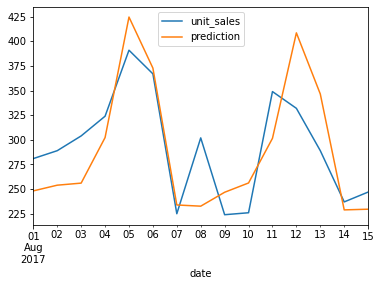

In [30]:
test.plot()

Although I took very simplified model I obtain almost 40% of accuracy. The best results on Kaggle had around 50%. Also the plot shows not too bed estimation. The peek 8 August was not caught but the rest seems to be OK.

Things TODO for the future:
1. Perform more systematic hyperparameter tuning
2. Use other ML algorithms
